In [1]:
import torch
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne
import numpy as np
import random
import argparse
from AutoEncoderDecoder import AutoEncoderCIFAR, EncoderCIFAR
from AutoEncoderDecoder import DecoderCIFAR
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
# Argument parser for command-line arguments
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--seed', default=0, type=int, help='Seed for random number generators')
    parser.add_argument('--data-path', default="~/datasets/cv_datasets/data", type=str, help='Path to dataset')
    parser.add_argument('--batch-size', default=8, type=int, help='Size of each batch')
    parser.add_argument('--latent-dim', default=128, type=int, help='Encoding dimension')
    parser.add_argument('--device', default='cuda' if torch.cuda.is_available() else 'cpu', type=str, help='Default device to use')
    parser.add_argument('--mnist', action='store_true', default=False, help='Use MNIST (True) or CIFAR10 (False) data')
    parser.add_argument('--self-supervised', action='store_true', default=False, help='Train self-supervised or jointly with classifier')
    parser.add_argument('--debug', action='store_true', default=False, help='Enable debugging for dataloader')
    args, unknown =  parser.parse_args()
    return args

NUM_CLASSES = 10

In [3]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

In [5]:
freeze_seeds(0)

In [6]:
import os
current_dir = os.getcwd()
train_dataset = datasets.CIFAR10(root=current_dir, train=True, download=True, transform=transform)
class_names = train_dataset.classes 
test_dataset = datasets.CIFAR10(root=current_dir, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Function to rescale images back from [-1, 1] to [0, 1]
def rescale_image(image):
    return np.clip((image + 1) / 2, 0, 1)  # Rescale from [-1, 1] to [0, 1]

# Function to plot reconstructed images (rescale after reconstruction)
def plot_reconstruction(original, reconstructed, num_images=10):
    original = original.cpu().detach().numpy()
    reconstructed = reconstructed.cpu().detach().numpy()
    
    # Rescale images to [0, 1] range for visualization
    original = rescale_image(original)
    reconstructed = rescale_image(reconstructed)
    num_images = min(num_images, original.shape[0])  # Ensure we don't exceed batch size
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 20))

    for i in range(num_images):
        ax = axes[i, 0]
        ax.imshow(np.transpose(original[i], (1, 2, 0)))  # Reorder dimensions to (H, W, C)
        ax.set_title('Original')
        ax.axis('off')

        ax = axes[i, 1]
        ax.imshow(np.transpose(reconstructed[i], (1, 2, 0)))
        ax.set_title('Reconstructed')
        ax.axis('off')

    plt.show()
    

Epoch 1, Loss: 0.07164460408501327
Test Reconstruction Loss: 0.0574


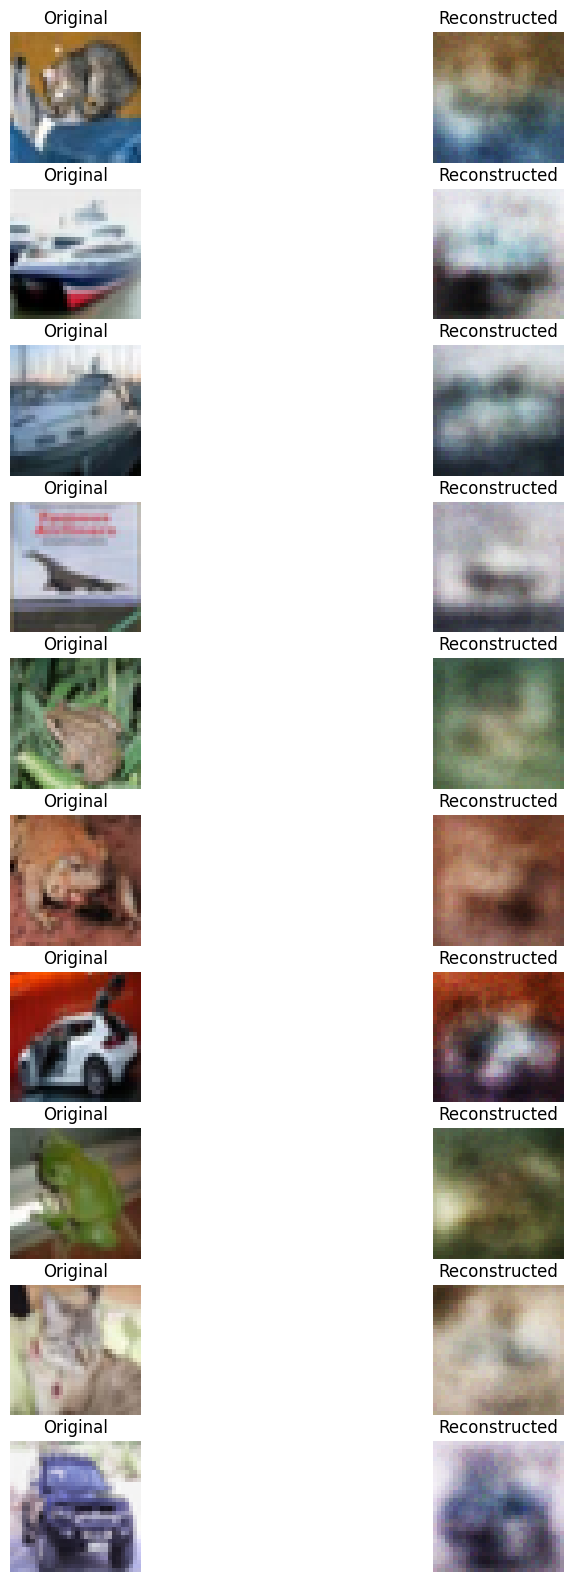

In [10]:
train_size = int(0.8 * len(train_dataset))
val_size   = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader 
dl_train = DataLoader(train_dataset, batch_size=16, shuffle=True)
dl_test  = DataLoader(test_dataset, batch_size=16, shuffle=False)
dl_val   = DataLoader(val_dataset, batch_size=16, shuffle=False)

im_size = train_dataset[0][0].shape

# Initialize the autoencoder and the optimizer
latent_dim = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#encoder = EncoderCIFAR(latent_dim).to(device)
#decoder= DecoderCIFAR(latent_dim).to(device)
autoencoder = AutoEncoderCIFAR(latent_dim).to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Training loop for self-supervised task
num_epochs = 1
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data in dl_train:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        reconstructed, _ = autoencoder(images)
        loss = criterion(reconstructed, images)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(dl_train)  # Average loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss}")

    # Plot reconstructions after training
    with torch.no_grad():
        test_images, _ = next(iter(dl_test))
        test_images = test_images.to(device)
        reconstructed, _ = autoencoder(test_images)
        # Calculate the MSE loss (reconstruction loss)
        reconstruction_loss = criterion(reconstructed, test_images)
        print(f"Test Reconstruction Loss: {reconstruction_loss.item():.4f}")
        plot_reconstruction(test_images, reconstructed)
        

In [11]:
# Function to plot images with labels and predictions
def plot_images_with_labels(images, true_labels, predicted_labels, class_names, num_images=10):
    images = images.cpu().detach().numpy()  # Convert to numpy (on CPU)
    true_labels = true_labels.cpu().detach().numpy()  # True labels
    predicted_labels = predicted_labels.cpu().detach().numpy()  # Predicted labels
    
    num_images = min(num_images, images.shape[0])  # Ensure we don't exceed batch size
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        ax = axes[i]
        ax.imshow(np.transpose(images[i], (1, 2, 0)))  # Reorder to (H, W, C)
        ax.set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        ax.axis('off')  # Hide axes

    plt.show()

In [20]:
#### Classifier Model ###

#basic:
# class Classifier(torch.nn.Module):
#     def __init__(self, latent_dim, num_classes):
#         super(Classifier, self).__init__()
#         self.fc = torch.nn.Linear(latent_dim, num_classes)  

#     def forward(self, x):
#         return self.fc(x)  

# class Classifier(torch.nn.Module):
#     def __init__(self, latent_dim, num_classes):
#         super(Classifier, self).__init__()
#         self.fc1 = torch.nn.Linear(latent_dim, 512)
#         self.relu = torch.nn.ReLU()
#         self.fc2 = torch.nn.Linear(512, num_classes)  # Final output layer

#     def forward(self, x):
#         x = self.relu(self.fc1(x))  # Hidden layer with ReLU
#         return self.fc2(x)  # Output layer for classification


class Classifier(torch.nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(Classifier, self).__init__()

        # Define the layers
        self.fc1 = torch.nn.Linear(latent_dim, 512)
        self.relu1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(512)  # Batch normalization after the first hidden layer
        self.drop1 = torch.nn.Dropout(0.5)  # Dropout layer to prevent overfitting

        self.fc2 = torch.nn.Linear(512, 256)
        self.relu2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm1d(256)
        self.drop2 = torch.nn.Dropout(0.5)

        self.fc3 = torch.nn.Linear(256, num_classes)  # Final output layer (classification)

    def forward(self, x):
        x = self.relu1(self.bn1(self.fc1(x)))  # Apply fc1 + ReLU + BatchNorm
        x = self.drop1(x)  # Apply dropout
        
        x = self.relu2(self.bn2(self.fc2(x)))  # Apply fc2 + ReLU + BatchNorm
        x = self.drop2(x)  # Apply dropout
        
        x = self.fc3(x)  # Final classification layer (logits)
        return x



In [21]:
for param in autoencoder.encoder.parameters(): # Freeze encoder weights
    param.requires_grad = False

In [22]:
# Initialize the classifier and optimizer
classifier = Classifier(latent_dim, NUM_CLASSES).to(device)
classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion_classifier = torch.nn.CrossEntropyLoss()

# Training loop for classifier
num_epochs = 10  
for epoch in range(num_epochs):
    classifier.train()  # training mode
    epoch_loss = 0.0
    correct = 0
    total = 0

    for data in dl_train:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Get latent representation from the encoder 
        with torch.no_grad():
            latent = autoencoder.encoder(images)

        classifier_optimizer.zero_grad() 
        outputs = classifier(latent) 

        loss = criterion_classifier(outputs, labels)  # Cross-Entropy Loss
        loss.backward()  # Backpropagate
        classifier_optimizer.step()  # Update classifier weights

        epoch_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = epoch_loss / len(dl_train)
    accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")


Epoch 1, Loss: 1.8402, Accuracy: 33.96%
Epoch 2, Loss: 1.7203, Accuracy: 38.45%
Epoch 3, Loss: 1.6846, Accuracy: 39.55%
Epoch 4, Loss: 1.6497, Accuracy: 40.67%
Epoch 5, Loss: 1.6267, Accuracy: 41.89%
Epoch 6, Loss: 1.6164, Accuracy: 42.36%
Epoch 7, Loss: 1.5972, Accuracy: 42.99%
Epoch 8, Loss: 1.5862, Accuracy: 43.25%
Epoch 9, Loss: 1.5689, Accuracy: 44.16%
Epoch 10, Loss: 1.5582, Accuracy: 44.14%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to 

Test Loss: 1.4180
Test Accuracy: 49.70%


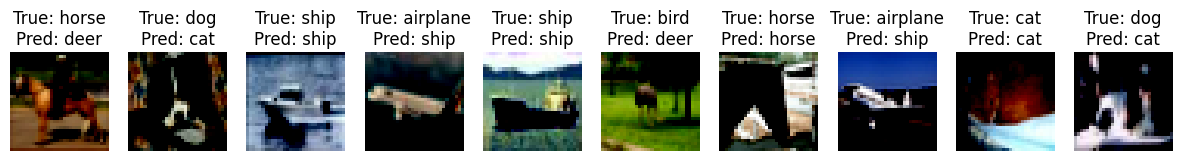

In [24]:
# Test the classifier on the test set
classifier.eval()  # Set classifier to evaluation mode
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for data in dl_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        latent = autoencoder.encoder(images)
        outputs = classifier(latent)

        # Calculate loss
        loss = criterion_classifier(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(dl_test):.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


# Visualize the images along with their true and predicted labels
plot_images_with_labels(images, labels, predicted, class_names, num_images=10)


In [25]:
###Classification-Guided Encoding###

encoder = EncoderCIFAR(latent_dim=128).to(device)  # Using the encoder only
classifier = Classifier(latent_dim=128, num_classes=NUM_CLASSES).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(classifier.parameters()), lr=1e-3)
criterion_classifier = torch.nn.CrossEntropyLoss()

# Training loop 
num_epochs = 10
for epoch in range(num_epochs):
    encoder.train()  # training mode
    classifier.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for data in dl_train:  
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        latent = encoder(images)  
        outputs = classifier(latent)

        # Compute loss
        loss = criterion_classifier(outputs, labels)
        loss.backward() 
        optimizer.step()  

        epoch_loss += loss.item()  
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_epoch_loss = epoch_loss / len(dl_train)  
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")



Epoch 1, Loss: 1.8387, Accuracy: 33.86%
Epoch 2, Loss: 1.6429, Accuracy: 41.43%
Epoch 3, Loss: 1.5519, Accuracy: 44.85%
Epoch 4, Loss: 1.4947, Accuracy: 46.83%
Epoch 5, Loss: 1.4450, Accuracy: 49.14%
Epoch 6, Loss: 1.3964, Accuracy: 50.43%
Epoch 7, Loss: 1.3696, Accuracy: 51.68%
Epoch 8, Loss: 1.3332, Accuracy: 53.09%
Epoch 9, Loss: 1.2944, Accuracy: 54.58%
Epoch 10, Loss: 1.2634, Accuracy: 55.53%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9137255].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..1.0].
Clipping input data to 

Test Loss: 1.3664
Test Accuracy: 51.48%


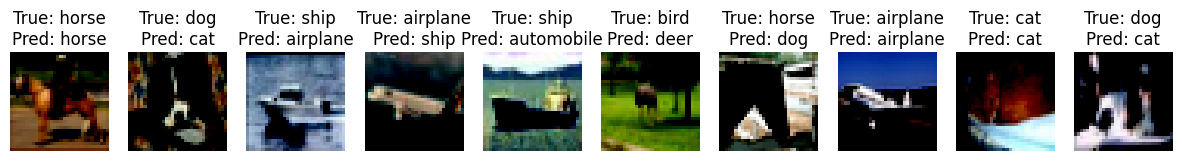

In [26]:
# Evaluate the classifier on the test set
encoder.eval()  # Set encoder and classifier to evaluation mode
classifier.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data in dl_test:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Get latent representation from the encoder
        latent = encoder(images)  # Encoder only

        # Classifier output
        outputs = classifier(latent)

        # Calculate loss
        loss = criterion_classifier(outputs, labels)
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss / len(dl_test):.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
# Visualize the images along with their true and predicted labels
plot_images_with_labels(images, labels, predicted, class_names, num_images=10)
